In [1]:
# Implement perceptron, average perceptron, and pegasos
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pdb
import itertools
import operator
import functools

print("Importing code_for_hw03")

######################################################################
# Plotting

def tidy_plot(xmin, xmax, ymin, ymax, center = False, title = None,
                 xlabel = None, ylabel = None):
    plt.ion()
    plt.figure(facecolor="white")
    ax = plt.subplot()
    if center:
        ax.spines['left'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position('zero')
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_smart_bounds(True)
        ax.spines['bottom'].set_smart_bounds(True)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    else:
        ax.spines["top"].set_visible(False)    
        ax.spines["right"].set_visible(False)    
        ax.get_xaxis().tick_bottom()  
        ax.get_yaxis().tick_left()
    eps = .05
    plt.xlim(xmin-eps, xmax+eps)
    plt.ylim(ymin-eps, ymax+eps)
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    return ax

def plot_separator(ax, th, th_0):
    xmin, xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    pts = []
    eps = 1.0e-6
    # xmin boundary crossing is when xmin th[0] + y th[1] + th_0 = 0
    # that is, y = (-th_0 - xmin th[0]) / th[1]
    if abs(th[1,0]) > eps:
        pts += [np.array([x, (-th_0 - x * th[0,0]) / th[1,0]]) \
                                                        for x in (xmin, xmax)]
    if abs(th[0,0]) > 1.0e-6:
        pts += [np.array([(-th_0 - y * th[1,0]) / th[0,0], y]) \
                                                         for y in (ymin, ymax)]
    in_pts = []
    for p in pts:
        if (xmin-eps) <= p[0] <= (xmax+eps) and \
           (ymin-eps) <= p[1] <= (ymax+eps):
            duplicate = False
            for p1 in in_pts:
                if np.max(np.abs(p - p1)) < 1.0e-6:
                    duplicate = True
            if not duplicate:
                in_pts.append(p)
    if in_pts and len(in_pts) >= 2:
        # Plot separator
        vpts = np.vstack(in_pts)
        ax.plot(vpts[:,0], vpts[:,1], 'k-', lw=2)
        # Plot normal
        vmid = 0.5*(in_pts[0] + in_pts[1])
        scale = np.sum(th*th)**0.5
        diff = in_pts[0] - in_pts[1]
        dist = max(xmax-xmin, ymax-ymin)
        vnrm = vmid + (dist/10)*(th.T[0]/scale)
        vpts = np.vstack([vmid, vnrm])
        ax.plot(vpts[:,0], vpts[:,1], 'k-', lw=2)
        # Try to keep limits from moving around
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
    else:
        print('Separator not in plot range')

def plot_data(data, labels, ax = None, clear = False,
                  xmin = None, xmax = None, ymin = None, ymax = None):
    if ax is None:
        if xmin == None: xmin = np.min(data[0, :]) - 0.5
        if xmax == None: xmax = np.max(data[0, :]) + 0.5
        if ymin == None: ymin = np.min(data[1, :]) - 0.5
        if ymax == None: ymax = np.max(data[1, :]) + 0.5
        ax = tidy_plot(xmin, xmax, ymin, ymax)

        x_range = xmax - xmin; y_range = ymax - ymin
        if .1 < x_range / y_range < 10:
            ax.set_aspect('equal')
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
    elif clear:
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        ax.clear()
    else:
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
    colors = np.choose(labels > 0, cv(['r', 'g']))[0]
    ax.scatter(data[0,:], data[1,:], c = colors,
                    marker = 'o', s=50, edgecolors = 'none')
    # Seems to occasionally mess up the limits
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.grid(True, which='both')
    #ax.axhline(y=0, color='k')
    #ax.axvline(x=0, color='k')
    return ax

# Must either specify limits or existing ax
def plot_nonlin_sep(predictor, ax = None, xmin = None , xmax = None,
                        ymin = None, ymax = None, res = 30):
    if ax is None:
        ax = tidy_plot(xmin, xmax, ymin, ymax)
    else:
        if xmin == None:
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
        else:
            ax.set_xlim((xmin, xmax))
            ax.set_ylim((ymin, ymax))

    cmap = colors.ListedColormap(['black', 'white'])
    bounds=[-2,0,2]
    norm = colors.BoundaryNorm(bounds, cmap.N)            
            
    ima = np.array([[predictor(x1i, x2i) \
                         for x1i in np.linspace(xmin, xmax, res)] \
                         for x2i in np.linspace(ymin, ymax, res)])
    im = ax.imshow(np.flipud(ima), interpolation = 'none',
                       extent = [xmin, xmax, ymin, ymax],
                       cmap = cmap, norm = norm)

######################################################################
#   Utilities

# Takes a list of numbers and returns a column vector:  n x 1
def cv(value_list):
    return np.transpose(rv(value_list))

# Takes a list of numbers and returns a row vector: 1 x n
def rv(value_list):
    return np.array([value_list])

# x is dimension d by 1
# th is dimension d by 1
# th0 is a scalar
# return a 1 by 1 matrix
def y(x, th, th0):
   return np.dot(np.transpose(th), x) + th0

# x is dimension d by 1
# th is dimension d by 1
# th0 is dimension 1 by 1
# return 1 by 1 matrix of +1, 0, -1
def positive(x, th, th0):
   return np.sign(y(x, th, th0))

# data is dimension d by n
# labels is dimension 1 by n
# ths is dimension d by 1
# th0s is dimension 1 by 1
# return 1 by 1 matrix of integer indicating number of data points correct for
# each separator.
def score(data, labels, th, th0):
   return np.sum(positive(data, th, th0) == labels)

######################################################################
#   Data Sets

# Return d = 2 by n = 4 data matrix and 1 x n = 4 label matrix
def super_simple_separable_through_origin():
    X = np.array([[2, 3, 9, 12],
                  [5, 1, 6, 5]])
    y = np.array([[1, -1, 1, -1]])
    return X, y

def super_simple_separable():
    X = np.array([[2, 3, 9, 12],
                  [5, 2, 6, 5]])
    y = np.array([[1, -1, 1, -1]])
    return X, y

def xor():
    X = np.array([[1, 2, 1, 2],
                  [1, 2, 2, 1]])
    y = np.array([[1, 1, -1, -1]])
    return X, y

def xor_more():
    X = np.array([[1, 2, 1, 2, 2, 4, 1, 3],
                  [1, 2, 2, 1, 3, 1, 3, 3]])
    y = np.array([[1, 1, -1, -1, 1, 1, -1, -1]])
    return X, y

######################################################################
#   Tests for part 2:  features

# Make it take miscellaneous args and pass into learner
def test_linear_classifier_with_features(dataFun, learner, feature_fun,
                             draw = True, refresh = True, pause = True):
    raw_data, labels = dataFun()
    data = feature_fun(raw_data) if feature_fun else raw_data
    if draw:
        ax = plot_data(raw_data, labels)
        def hook(params):
            (th, th0) = params
            plot_nonlin_sep(
                lambda x1,x2: int(positive(feature_fun(cv([x1, x2])), th, th0)),
                ax = ax)
            plot_data(raw_data, labels, ax)
            plt.pause(0.05)
            print('th', th.T, 'th0', th0)
            if pause: input('press enter here to continue:')
    else:
        hook = None
    th, th0 = learner(data, labels, hook = hook)
    if hook: hook((th, th0))
    print("Final score", int(score(data, labels, th, th0)))
    print("Params", np.transpose(th), th0)

def mul(seq):
    return functools.reduce(operator.mul, seq, 1)

def make_polynomial_feature_fun(order):
    # raw_features is d by n
    # return is k by n where k = sum_{i = 0}^order  multichoose(d, i)
    def f(raw_features):
        d, n = raw_features.shape
        result = []   # list of column vectors
        for j in range(n):
            features = []
            for o in range(order+1):
                indexTuples = \
                          itertools.combinations_with_replacement(range(d), o)
                for it in indexTuples:
                    features.append(mul(raw_features[i, j] for i in it))
            result.append(cv(features))
        return np.hstack(result)
    return f

def test_with_features(dataFun, order = 2, draw=True, pause=True):
    test_linear_classifier_with_features(
        dataFun,                        # data
        perceptron,                     # learner
        make_polynomial_feature_fun(order), # feature maker
        draw=draw,
        pause=pause)

# Perceptron algorithm with offset.
# data is dimension d by n
# labels is dimension 1 by n
# T is a positive integer number of steps to run
def perceptron(data, labels, params = {}, hook = None):
    T = params.get('T', 100)
    (d, n) = data.shape
    m = 0
    theta = np.zeros((d, 1)); theta_0 = np.zeros((1, 1))
    for t in range(T):
        for i in range(n):
            x = data[:,i:i+1]
            y = labels[:,i:i+1]
            if y * positive(x, theta, theta_0) <= 0.0:
                m += 1
                theta = theta + y * x
                theta_0 = theta_0 + y
                if hook: hook((theta, theta_0))
    return theta, theta_0, m




######################################################################
#   Tests for part 2D:  Encoding discrete values

def one_hot_internal(x, k):
    # Make an empty column vector
    v = np.zeros((k, 1))
    # Set an entry to 1
    v[x-1, 0] = 1
    return v

def test_one_hot(sub):
    if one_hot_internal(3, 5).tolist() == sub(3, 5).tolist() and one_hot_internal(4, 7).tolist() == sub(4, 7).tolist():
        print("Passed! \n")
    else: print("Test Failed")

#-----------------------------------------------------------------------------
print("Imported tidy_plot, plot_separator, plot_data, plot_nonlin_sep, cv, rv, y, positive, score")
print("Datasets: super_simple_separable_through_origin(), super_simple_separable(), xor(), xor_more()")
print("Tests for part 2: test_linear_classifier_with_features, mul, make_polynomial_feature_fun, ")
print("                  test_with_features")
print("Also loaded: perceptron, one_hot_internal, test_one_hot")

######################################################################
#   Example for part 3B) test_with_features()
#test_with_features(super_simple_separable, 2, draw=True, pause=True)


Importing code_for_hw03
Imported tidy_plot, plot_separator, plot_data, plot_nonlin_sep, cv, rv, y, positive, score
Datasets: super_simple_separable_through_origin(), super_simple_separable(), xor(), xor_more()
Tests for part 2: test_linear_classifier_with_features, mul, make_polynomial_feature_fun, 
                  test_with_features
Also loaded: perceptron, one_hot_internal, test_one_hot


#### Margin calcuator


In [2]:
import numpy as np

# Veri seti
data = np.array([[200, 800, 200, 800],
                [0.2,  0.2,  0.8,  0.8],
                [1,1,1,1]])

# Etiketler
labels = np.array([[-1, -1, 1, 1]])

# Sınıflandırıcı parametreleri
w = np.array([0, 1, -0.5])

# Marjin hesaplama fonksiyonu
def calculate_margin(w, x, y):
    return y * np.dot(w, x) / np.linalg.norm(w)

(d, n) = data.shape

# Her veri noktası için marjini hesapla
margins = [calculate_margin(w, data[:,i:i+1], labels[:,i:i+1]) for i in range(d)]

# En küçük marjini bul
min_margin = min(margins)
print(min_margin.flatten())


[0.26832816]


In [3]:
# Veri noktalarının maksimum normunu hesapla
max_norm = max(np.linalg.norm(data[:,i:i+1]) for i in range(d))

# Teorik hata sınırını hesapla
theoretical_bound = (max_norm ** 2) / (min_margin ** 2)

# Sonucu yazdır
print(f"Teorik Hata Sınırı: {theoretical_bound}")
print(((max(np.linalg.norm(data[:,i:i+1]) for i in range(d))) ** 2) / (min_margin ** 2))

Teorik Hata Sınırı: [[8888903.33333334]]
[[8888903.33333334]]


In [4]:
def perceptron(data, labels, params = {}, hook = None):
    T = params.get('T', 100)
    (d, n) = data.shape
    m = 0
    theta = np.array([[0],[0],[0]]); theta_0 = np.array([[0]])
    for t in range(T):
        for i in range(n):
            x = data[:,i:i+1]
            y = labels[:,i:i+1]
            if y * positive(x, theta, theta_0) <= 0.0:
                m += 1
                theta = theta + y * x
                #theta_0 = theta_0 + y
                if hook: hook((theta, theta_0))
    return theta, theta_0, m

data = np.array([[200, 800, 200, 800],
                [0.2,  0.2,  0.8,  0.8],
                [1,1,1,1]])

# Etiketler
labels = np.array([[-1, -1, 1, 1]])
params = {'T': 1000}  # 100 iterasyon için parametre

theta, theta_0, m = perceptron(data, labels,params=params)

print(f"Ağırlıklar (theta): \n{theta}")
print(f"Bias (theta_0): \n{theta_0}")
print(m)

Ağırlıklar (theta): 
[[  0.]
 [600.]
 [  0.]]
Bias (theta_0): 
[[0]]
2000


In [5]:
import numpy as np

# Veri seti
data = np.array([[200, 800, 200, 800],
                [0.2,  0.2,  0.8,  0.8],
                [1,1,1,1]])
data[0] = data[0] * 0.001

# Etiketler
labels = np.array([[-1, -1, 1, 1]])

# Sınıflandırıcı parametreleri
w = np.array([0, 1, -0.5])

# Marjin hesaplama fonksiyonu
def calculate_margin(w, x, y):
    return y * np.dot(w, x) / np.linalg.norm(w)

(d, n) = data.shape

# Her veri noktası için marjini hesapla
margins = [calculate_margin(w, data[:,i:i+1], labels[:,i:i+1]) for i in range(d)]

# En küçük marjini bul
min_margin = min(margins)
print(min_margin.flatten())


[0.26832816]


In [6]:
def perceptron(data, labels, params = {}, hook = None):
    T = params.get('T', 100)
    (d, n) = data.shape
    m = 0
    theta = np.array([[0],[0],[0]]); theta_0 = np.array([[0]])
    for t in range(T):
        for i in range(n):
            x = data[:,i:i+1]
            y = labels[:,i:i+1]
            if y * positive(x, theta, theta_0) <= 0.0:
                m += 1
                theta = theta + y * x
                #theta_0 = theta_0 + y
                if hook: hook((theta, theta_0))
    return theta, theta_0, m

data = np.array([[200, 800, 200, 800],
                [0.2,  0.2,  0.8,  0.8],
                [1,1,1,1]])
data[0] = data[0] * 0.001

# Etiketler
labels = np.array([[-1, -1, 1, 1]])
params = {'T': 10000}  # 100 iterasyon için parametre

theta, theta_0, m = perceptron(data, labels,params=params)

print(f"Ağırlıklar (theta): \n{theta}")
print(f"Bias (theta_0): \n{theta_0}")
print(m)

Ağırlıklar (theta): 
[[-0.2]
 [ 1.6]
 [-1. ]]
Bias (theta_0): 
[[0]]
7


In [7]:
def perceptron(data, labels, params = {}, hook = None):
    T = params.get('T', 100)
    (d, n) = data.shape
    m = 0
    theta = np.array([[0]]); theta_0 = np.array([[0]])
    for t in range(T):
        for i in range(n):
            x = data[:,i:i+1]
            y = labels[:,i:i+1]
            if y * positive(x, theta, theta_0) <= 0.0:
                m += 1
                theta = theta + y * x
                theta_0 = theta_0 + y
                if hook: hook((theta, theta_0))
    return theta, theta_0, m

data = np.array([[2, 3, 4, 5]])
labels = np.array([[1, 1, -1, -1]])

# Etiketler
labels = np.array([[-1, -1, 1, 1]])
params = {'T': 10000}  # 100 iterasyon için parametre

theta, theta_0, m = perceptron(data, labels,params=params)

print(f"Ağırlıklar (theta): \n{theta}")
print(f"Bias (theta_0): \n{theta_0}")
print(m)



Ağırlıklar (theta): 
[[2]]
Bias (theta_0): 
[[-7]]
29


In [8]:
def one_hot(x, k):
    d = np.zeros((k,1))
    d[x-1]=1;
    return d

## `one_hot` Fonksiyonu Açıklaması

Bu fonksiyon, verilen bir sınıf etiketini `one-hot` kodlamasına dönüştürür. `one-hot` kodlama, bir kategorik değişkeni binary (ikili) vektör formatında temsil etmenin yaygın bir yoludur. Her vektörde yalnızca bir eleman `1` değerini alır, diğer tüm elemanlar `0` olur. Bu, sınıf etiketinin konumunu belirtir.

### Fonksiyon Tanımı

```python
def one_hot(x, k):
    d = np.zeros((k, 1))
    d[x-1] = 1
    return d


In [9]:

data = np.array([[2, 3,  4,  5]])
labels = np.array([[1, 1, -1, -1]])

(d, n) = data.shape

hot_data = np.hstack([one_hot_internal(data[0, i], 6) for i in range(n)])

print(hot_data)
# Perceptron fonksiyonunun tanımlanması
def perceptron(data, labels, params = {}, hook = None):
    T = params.get('T', 100)
    (d, n) = data.shape
    m = 0
    theta = np.zeros((d, 1)); theta_0 = np.zeros((1, 1))
    for t in range(T):
        for i in range(n):
            x = data[:,i:i+1]
            y = labels[:,i:i+1]
            if y * positive(x, theta, theta_0) <= 0.0:
                m += 1
                theta = theta + y * x
                theta_0 = theta_0 + y
                if hook: hook((theta, theta_0))
    return theta, theta_0, m


# Etiketler
params = {'T': 1000}  # 100 iterasyon için parametre

theta, theta_0,m = perceptron(hot_data, labels,params=params)

print(f"Ağırlıklar (theta): \n{theta}")
print(f"Bias (theta_0): \n{theta_0}")
print(m)

[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
Ağırlıklar (theta): 
[[ 0.]
 [ 2.]
 [ 1.]
 [-2.]
 [-1.]
 [ 0.]]
Bias (theta_0): 
[[0.]]
6


In [10]:
# One-hot encoding veri seti oluşturma fonksiyonu
def one_hot_encode_data(data, num_classes):
    n = data.shape[1]
    return np.hstack([one_hot_internal(data[0, i], num_classes) for i in range(n)])

In [11]:
num_classes = 6
# Samsung ve Nokia için one-hot kodlanmış vektörler
# Samsung = 1, Nokia = 6
samsung_one_hot = one_hot_internal(1, num_classes)
nokia_one_hot = one_hot_internal(6, num_classes)

# Tahminleri yapma
def predict(x, theta, theta_0):
    return 1 if positive(x, theta, theta_0) > 0 else -1

samsung_prediction = predict(samsung_one_hot, theta, theta_0)
nokia_prediction = predict(nokia_one_hot, theta, theta_0)

# Tahminleri yazdırma
print(f"Samsung için tahmin: {samsung_prediction}")
print(f"Nokia için tahmin: {nokia_prediction}")

# Sonuçları bir liste olarak döndürme
predictions = [samsung_prediction, nokia_prediction]
print(predictions)


Samsung için tahmin: -1
Nokia için tahmin: -1
[-1, -1]


In [12]:
# Mesafe hesaplama fonksiyonu
def distance_from_separator(x, theta, theta_0):
    return np.abs(positive(x, theta, theta_0)) / np.linalg.norm(theta)

# Mesafeleri hesaplama
samsung_distance = distance_from_separator(samsung_one_hot, theta, theta_0)
nokia_distance = distance_from_separator(nokia_one_hot, theta, theta_0)

# Mesafeleri yazdırma
print(f"Samsung için mesafe: {samsung_distance}")
print(f"Nokia için mesafe: {nokia_distance}")

Samsung için mesafe: [[0.]]
Nokia için mesafe: [[0.]]


In [13]:
data =   np.array([[1, 2, 3, 4, 5, 6]])
labels = np.array([[1, 1, -1, -1, 1, 1]])

n = data.shape[1]
hot_data = np.hstack([one_hot_internal(data[0, i], 6) for i in range(n)])
print(hot_data)

theta, theta_0,m = perceptron(hot_data, labels)
print(f"Ağırlıklar (theta): \n{theta}")
print(f"Bias (theta_0): \n{theta_0}")

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
Ağırlıklar (theta): 
[[ 1.]
 [ 1.]
 [-2.]
 [-2.]
 [ 1.]
 [ 1.]]
Bias (theta_0): 
[[0.]]


In [14]:
data =  np.array([1, 10, 20, 30, 40, 50])
data2 =  np.array([[5],
                   [2]])
print(data2)

for i in data:
    pol_data = make_polynomial_feature_fun(i)
    print(pol_data(data2).shape)


[[5]
 [2]]
(3, 1)
(66, 1)
(231, 1)
(496, 1)
(861, 1)
(1326, 1)


/var/folders/kc/txgh3xkn0xgfsxb3fpxhwsvc0000gn/T/ipykernel_84269/808165638.py:224: RuntimeWarning: overflow encountered in long_scalars
  return functools.reduce(operator.mul, seq, 1)


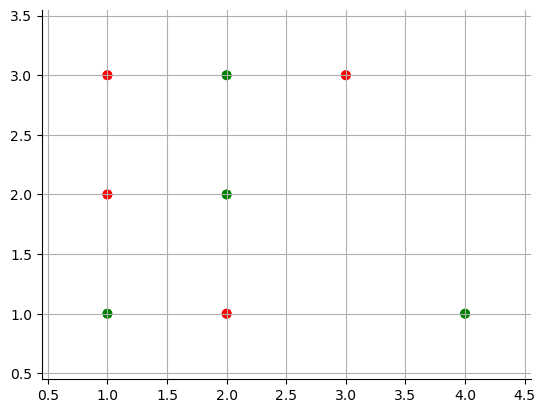

th [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]] th0 [[1.]]
th [[ 0.  0. -1.  0. -1. -3.  0. -1. -3. -7.]] th0 [[0.]]
th [[ 1.  2.  2.  4.  5.  6.  8. 11. 15. 20.]] th0 [[1.]]
th [[ 0.  1. -1.  3.  2. -3.  7.  8.  6. -7.]] th0 [[0.]]
th [[ -1.  -2.  -4.  -6.  -7. -12. -20. -19. -21. -34.]] th0 [[-1.]]
th [[  0.  -1.  -3.  -5.  -6. -11. -19. -18. -20. -33.]] th0 [[0.]]
th [[  1.   1.  -1.  -1.  -2.  -7. -11. -10. -12. -25.]] th0 [[1.]]
th [[ 2.  3.  2.  3.  4.  2. -3.  2.  6.  2.]] th0 [[2.]]
th [[ 3.  7.  3. 19.  8.  3. 61. 18. 10.  3.]] th0 [[3.]]
th [[  2.   6.   0.  18.   5.  -6.  60.  15.   1. -24.]] th0 [[2.]]
th [[  1.   3.  -3.   9.  -4. -15.  33. -12. -26. -51.]] th0 [[1.]]
th [[  2.   4.  -2.  10.  -3. -14.  34. -11. -25. -50.]] th0 [[2.]]
th [[  3.   6.   0.  14.   1. -10.  42.  -3. -17. -42.]] th0 [[3.]]
th [[  2.   4.  -1.  10.  -1. -11.  34.  -7. -19. -43.]] th0 [[2.]]
th [[  3.   6.   2.  14.   5.  -2.  42.   5.  -1. -16.]] th0 [[3.]]
th [[  2.   3.  -1.   5.  -4. -11.  15. -22. -28.

In [40]:
data = np.array([[1, 1, 2, 2],
                 [1, 2, 1, 2]])
labels = np.array([[-1, 1, 1, -1]])

def perceptron(data, labels, params = {}, hook = None):
    T = params.get('T', 100)
    (d, n) = data.shape
    m = 0
    theta = np.zeros((d, 1))
    theta_0 = np.zeros((1, 1))
    for t in range(T):
        for i in range(n):
            x = data[:,i:i+1]
            y = labels[:,i:i+1]
            if y * positive(x, theta, theta_0) <= 0.0:
                m += 1
                theta = theta + y * x
                theta_0 = theta_0 + y
                if hook: hook((theta, theta_0))
    return theta, theta_0

test_with_features(xor_more,3, draw=True, pause=True)
